<p style="align: center;"><img src="https://static.tildacdn.com/tild3035-6336-4538-b034-363362346335/__2019_3.png", width=550, height=300></p>

## Установка зависимостей и загрузка датасета

In [1]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.2 MB/s eta 0:11:02tcmalloc: large alloc 1147494400 bytes == 0x6655a000 @  0x7f0c500e9615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████▋           | 1055.7 MB 1.3 MB/s eta 0:07:42tcmalloc: large alloc 1434370048 bytes == 0x3d82000 @  0x7f0c500e9615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |██████████████████████████▏     | 1

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import math
import torch
import torchvision
from skimage import io
import time
import copy

from sklearn.metrics import f1_score
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.io import read_image
from collections import Counter
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
torch.cuda.empty_cache()

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 299x299 px
RESCALE_SIZE = 299
# работаем на видеокарте (у меня не работает)
DEVICE = torch.device("cuda")
N_CORES = 2
BATCH_SIZE = 32

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def targets(self):
        return self.label_encoder.transform(self.labels)
    
    def __getitem__(self, index):
        # для преобразования изображений, аугментаций и нормализации входа
        transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(RESCALE_SIZE),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])          
            ]),
            'val': transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'test': transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        }
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform['test'](x)
            return x
        elif self.mode == 'train':
            x = transform['train'](x)
        else:
            x = transform['val'](x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
!mkdir ~/.kaggle 

In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c journey-springfield

 99% 517M/521M [00:13<00:00, 45.1MB/s]
100% 521M/521M [00:13<00:00, 41.1MB/s]


In [13]:
!unzip journey-springfield.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1039.jpg  
  in

In [14]:
DATA_DIR = "./"
TRAIN_DIR = Path(DATA_DIR + 'train/simpsons_dataset')
TEST_DIR = Path(DATA_DIR + 'testset/testset')

In [15]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [16]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [17]:
val_data = SimpsonsDataset(val_files, mode='val')
train_data = SimpsonsDataset(train_files, mode='train')
test_data = SimpsonsDataset(test_files, mode="test")

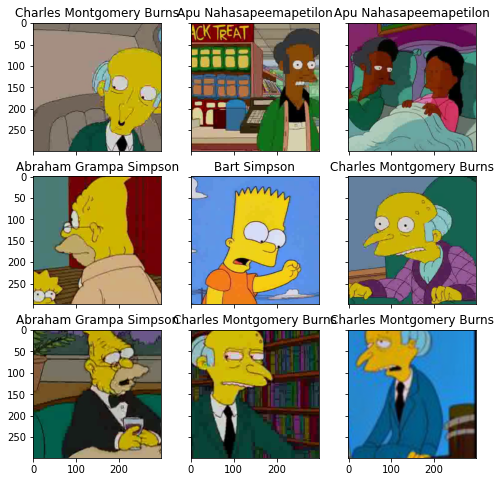

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_data[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_data.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Просмотр данных о распределении классов в датасете

In [19]:
n_classes = len(np.unique(train_val_labels))

In [20]:
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


In [21]:
train_labels = [path.parent.name for path in train_files]
pd.Series(train_labels).value_counts().sort_values().to_frame("count")

,count
lionel_hutz,2
troy_mcclure,6
disco_stu,6
miss_hoover,13
gil,20
fat_tony,20
otto_mann,24
sideshow_mel,30
agnes_skinner,32
rainier_wolfcastle,34


## Воспользуемся WheightedRandomSampler для устранения дисбаланса классов


In [22]:
class_count = Counter(train_data.targets())
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_data)
for i, (data, label) in enumerate(tqdm(train_data)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|██████████| 15699/15699 [01:35<00:00, 163.72it/s]


## Загрузим efficientnet для fine tuning-а

In [23]:
model_ext = models.efficientnet_b4(pretrained = True)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [24]:
model_ext.to(DEVICE)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

In [25]:
model_ext.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

In [26]:
model_ext.classifier[1] = nn.Linear(1792, n_classes).to(DEVICE)

In [27]:
for param in model_ext.parameters():
    param.requires_grad = False

In [28]:
for param in model_ext.features[5:8].parameters():
    param.requires_grad = True

In [29]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [30]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [31]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [32]:
def train(train_files, val_files, model, epochs, batch_size, train_sampler):
    train_loader = DataLoader(train_data, sampler = train_sampler, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adadelta(model.parameters())
        criterion = nn.CrossEntropyLoss()        
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            early_stopping(train_loss, val_loss )
            if early_stopping.early_stop:
                print("Stop learning, epoch:", epoch + 1)
                return history
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, step1=early_stopping.get_step()[0], step2=early_stopping.get_step()[1]))
            
    return history

## Создадим класс EarlyStopping для сохранения весов модели лучшей эпохи и для того, чтобы избежать переобучения и затухания градиентов

In [33]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter_over = 0
        self.counter_loss = -1
        self.early_stop = False
        self.prew_loss = 0
        self.model = model_ext
        
        self.less_loss = 999

    def get_step(self):
        return [int(self.counter_over), int(self.counter_loss)]
    def best_params(self):
        return self.best_params
    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter_over +=1
            if self.counter_over >= self.tolerance:  
                self.early_stop = True
        if validation_loss - self.prew_loss > 0:
            self.counter_loss += 1
            if self.counter_loss >= 6:  
                self.early_stop = True
        else:
            if validation_loss < self.less_loss:
                self.less_loss = validation_loss
                torch.save(model_ext.state_dict(), 'best-model.pt')

        self.prew_loss = validation_loss

In [34]:
early_stopping = EarlyStopping(tolerance=10, min_delta=0.7)

## Обучим нейросеть

In [35]:
hstr = train(train_data, val_data, model_ext, 20, BATCH_SIZE, train_sampler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.68247145165157


epoch:   5%|▌         | 1/20 [25:48<8:10:11, 1547.99s/it]


Epoch 001 train_loss: 1.6825     val_loss 0.1317 train_acc 0.5821 val_acc 0.9698
loss 0.4259026543098587


epoch:  10%|█         | 2/20 [50:32<7:33:09, 1510.54s/it]


Epoch 002 train_loss: 0.4259     val_loss 0.1598 train_acc 0.8916 val_acc 0.9629
loss 0.31625865429954575


epoch:  15%|█▌        | 3/20 [1:15:22<7:05:23, 1501.39s/it]


Epoch 003 train_loss: 0.3163     val_loss 0.1256 train_acc 0.9187 val_acc 0.9712
loss 0.2686467144970309


epoch:  20%|██        | 4/20 [1:40:09<6:38:50, 1495.64s/it]


Epoch 004 train_loss: 0.2686     val_loss 0.1014 train_acc 0.9308 val_acc 0.9786
loss 0.22952262136103735


epoch:  25%|██▌       | 5/20 [2:04:58<6:13:17, 1493.20s/it]


Epoch 005 train_loss: 0.2295     val_loss 0.1743 train_acc 0.9420 val_acc 0.9545
loss 0.2101131349744356


epoch:  30%|███       | 6/20 [2:29:48<5:48:10, 1492.15s/it]


Epoch 006 train_loss: 0.2101     val_loss 0.1015 train_acc 0.9460 val_acc 0.9765
loss 0.21400892292947574


epoch:  35%|███▌      | 7/20 [2:54:33<5:22:48, 1489.87s/it]


Epoch 007 train_loss: 0.2140     val_loss 0.1166 train_acc 0.9482 val_acc 0.9742
loss 0.13740142533454164


epoch:  40%|████      | 8/20 [3:19:24<4:58:02, 1490.22s/it]


Epoch 008 train_loss: 0.1374     val_loss 0.0859 train_acc 0.9638 val_acc 0.9824
loss 0.12335653493530689


epoch:  45%|████▌     | 9/20 [3:44:08<4:32:49, 1488.11s/it]


Epoch 009 train_loss: 0.1234     val_loss 0.0811 train_acc 0.9679 val_acc 0.9845
loss 0.11530814133370533


epoch:  50%|█████     | 10/20 [4:08:56<4:08:01, 1488.14s/it]


Epoch 010 train_loss: 0.1153     val_loss 0.0823 train_acc 0.9696 val_acc 0.9845
loss 0.11456749199772504


epoch:  55%|█████▌    | 11/20 [4:33:43<3:43:10, 1487.89s/it]


Epoch 011 train_loss: 0.1146     val_loss 0.0801 train_acc 0.9701 val_acc 0.9843
loss 0.11044214870757738


epoch:  60%|██████    | 12/20 [4:58:26<3:18:09, 1486.21s/it]


Epoch 012 train_loss: 0.1104     val_loss 0.0874 train_acc 0.9706 val_acc 0.9836
loss 0.10951565326971428


epoch:  65%|██████▌   | 13/20 [5:23:19<2:53:38, 1488.38s/it]


Epoch 013 train_loss: 0.1095     val_loss 0.0843 train_acc 0.9707 val_acc 0.9840
loss 0.10719882337225625


epoch:  65%|██████▌   | 13/20 [5:48:18<3:07:33, 1607.60s/it]

Stop learning, epoch: 14


обучалась 6 часов, я чуть не умер....

## Посмотрим на графики лоссов

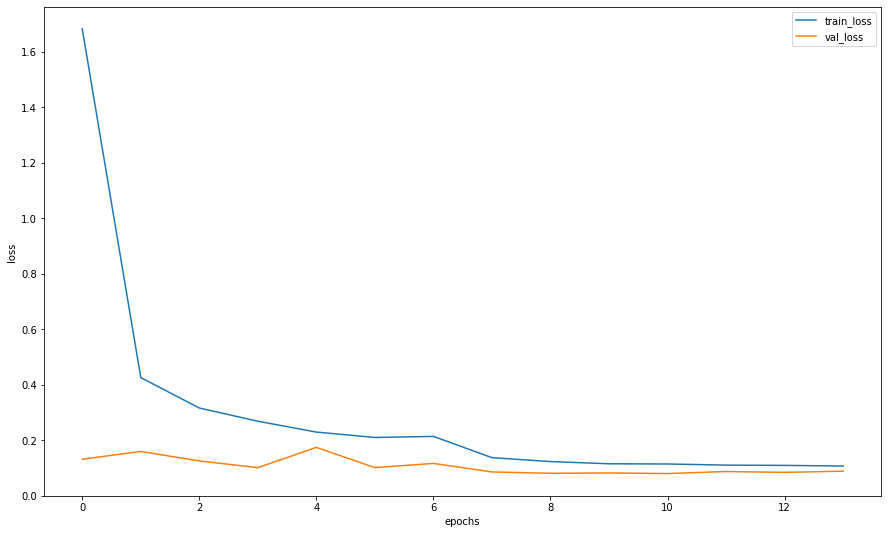

In [37]:
loss, acc, val_loss, val_acc = zip(*hstr)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Сделаем сабмит на каггл

In [38]:
import pandas as pd
my_submit = pd.DataFrame(columns=['Id', 'Expected'])

In [39]:
test_dataset = SimpsonsDataset(test_files, mode='test')

In [40]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [43]:
with open('label_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [45]:
probs = predict(model_ext, test_loader)

In [46]:
preds = encoder.inverse_transform(probs.argmax(axis=-1))

In [47]:
test_filenames = [path.name for path in test_dataset.files]

In [48]:
my_submit['Id'] = test_filenames
my_submit['Expected'] = preds

In [49]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [50]:
my_submit.to_csv('submit_1.csv', index=False)

In [51]:
model_ext.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [52]:
probs_1 = predict(model_ext, test_loader)

In [53]:
my_submit_1 = pd.DataFrame(columns=['Id', 'Expected'])

In [55]:
preds_1 = encoder.inverse_transform(probs_1.argmax(axis=-1))

In [56]:
my_submit_1['Id'] = test_filenames
my_submit_1['Expected'] = preds_1

In [57]:
my_submit_1.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [58]:
my_submit_1.to_csv('submit_2.csv', index=False)

## Результаты сабмита

**Имя в лидерборде:** Илья_Кудрявцев_508309351 \\
**Результат:** 0.99468 \\